In [2]:
import csv
import gc
import os
from os import walk
from time import sleep, time

import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from utils import *
from preprocess_utils import drop_too_many_na, simple_imputor, change_type, agg_data, separate_df_col
from scipy import stats
from loguru import logger
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from utils import getexception
import itertools
import os
from multiprocessing import Pool
logger.remove()
logger.add("./logs/6_6_3.log", rotation="500 MB", compression="zip", level="DEBUG", enqueue=True)
logger.add("./logs/6_6_3-info.log", level="INFO")

2

## Test process

## Start process

In [3]:

# EXP_NAME = "long_exception_bp_0.7-3.5_BL_Notch_ma_2"
RAW_DATA_FOLDER = "C:/Users/oplab/Desktop/聯發科PPG Raw Data"
# IMG_FOLDER = "./hp_csv/" + EXP_NAME
# ALL_FOLDER = "./hp_all/" + EXP_NAME

TIME_FORMAT = '%Y%m%d%H%M%S'
CLEAN_FOLDER = "./hp_all/clean_dataframe/"
FORMAT = '%(asctime)s  %(name)s  %(levelname)s  %(message)s'

NA_AMOUNT = 5


In [4]:
def get_target_cols():
    feature_col_map = {
        'ppg_time': ['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad',
                     'sd1', 'sd2', 's', 'sd1/sd2'],
        'ppg_freq': ['vlf', 'lf', 'hf', 'lf/hf', 'p_total',
                     'vlf_perc', 'lf_perc', 'hf_perc', 'lf_nu', 'hf_nu'],
        'acc_quantile': ['acc_q01', 'acc_q05', 'acc_q10',
                         'acc_q50', 'acc_q90', 'acc_q95', 'acc_q99'],
        'acc_agg': ['acc_max', 'acc_min', 'acc_mean'],
        'breath': ['breathingrate'],
        # 'ppg_entropy': ["en_ppg_perm", "en_ppg_spectral", "en_ppg_svd", "en_ppg_app", "en_ppg_sample", 'en_ppg_hjorth_l', 'en_ppg_hjorth_h',
        #                 "en_ppg_zerocross", "en_ppg_lziv", "en_ppg_petrosian", "en_ppg_katz", "en_ppg_higuchi", "en_ppg_detrend"],
        # 'acc_entropy': ["en_acc_perm", "en_acc_spectral", "en_acc_svd", "en_acc_app", "en_acc_sample", 'en_acc_hjorth_l', 'en_acc_hjorth_h',
        #                 "en_acc_zerocross", "en_acc_lziv", "en_acc_petrosian", "en_acc_katz", "en_acc_higuchi", "en_acc_detrend"]
                        
        'nyha': ['NYHA', 'NYHA2']
    }
    col = get_all_dict_values_into_list(feature_col_map)
    all_col = col + ['Event label', 'Event return', 'Event expire']
    all_col_with_time = all_col + ["timestamp", 'patient_id', 'csv num','Age ', 'Gender']
    return all_col_with_time

def get_all_patient_data(h5_path_list: list, label_df: pd.DataFrame) -> pd.DataFrame:
    # read each patient's h5 file and concat together
    df_list = []
    for idx, path in enumerate(h5_path_list):
        print(f"-> {idx}: {path}")

        allf_df = pd.read_hdf(path+".h5", key="df")
        label_columns = ['patient_id', 'csv num','Age ', 'Gender', 'NYHA', 'NYHA2', 'Event label', 'Event return', 'Event expire']
        patient_id_str= path.split("/")[-1].split("TVGH")[-1]
        
        labels_list = label_df[label_df["patient_id"] == int(patient_id_str)][label_columns]
        
        # Removing duplicate columns from labels_list
        for col in labels_list.columns:
            if col in allf_df.columns and col != 'patient_id':
                labels_list.drop(col, axis=1, inplace=True)

        # merge the patient data with the labels
        allf_df = pd.merge(allf_df, labels_list, how='left', on='patient_id')

        df_list.append(allf_df)

        try:
            del allf_df
            del labels_list
            gc.collect()
        except Exception as e:
            logger.error(f"get_all_patient_data gc error: {e}")

    alldf = pd.concat(df_list, axis=0, ignore_index=True)
    return alldf



## merge h5

In [7]:
test = False

def merge_h5(inputs):
    try:
        exp_name = inputs[1]
        pid = inputs[0]
        df_list = []
        patient_num = 'TVGH%03d' % pid
        h5_dir_path = f"./hp_all/all_segments_with_optimal_denoise/{exp_name}/{patient_num}"
        print(h5_dir_path + "\n")
        h5_file_list = next(walk(h5_dir_path), (None, None, []))[2] # get all files
        
        # if file name in h5_file_list contains TVGH, return
        if any("TVGH" in s for s in h5_file_list):
            print(f"already merge {exp_name}, {patient_num}")
            return


        for idx, filename in enumerate(h5_file_list):
            if filename.startswith("TVGH"):
                continue
            logger.info(f"iterate to : {idx}, {filename}")
            if test:
                continue
            df = pd.read_hdf(os.path.join(h5_dir_path, filename), key="df")
            df_list.append(df)
        if test:
            return
        alldf = pd.concat(df_list, axis=0, ignore_index=True)
        # replace '--' with np.nan
        alldf = alldf.replace('--', np.nan)
        # change object type columns to float
        alldf = change_type(alldf, 'sdsd', 'float')
        # inpute na with mean
        alldf.to_hdf(f"./hp_all/all_segments_with_optimal_denoise/{exp_name}/{patient_num}/{patient_num}.h5", key="df", mode="w")
        logger.info(f"finish {patient_num}")
    except Exception as e:
        logger.error(f"merge_h5 error: {h5_dir_path}, {e}")
        return


def main(PoolExecutor):
    # define patient folders
    patient_folder = sorted(os.listdir(CLEAN_FOLDER))
    pid_list = [int(x.replace("TVGH", "")) for x in patient_folder]
    
    
    # define denoise functinos
    data_folder_path = "hp_all/all_segments_with_optimal_denoise"
    denoise_function = os.listdir(data_folder_path)
    
     # test flag for input_files
    if test:
        denoise_function = denoise_function[:1]
    # logger.info(input_files, denoise_function)

    # generate input combinations
    input_combinations = itertools.product(pid_list, denoise_function)
    input_combinations = sorted(input_combinations, key=lambda x: x[1])
    
    exec_start = time()
    # with ProcessPoolExecutor(mp_context=mp.get_context('fork'), max_workers=4) as executor:
    try:
        with ProcessPoolExecutor(max_workers=4) as executor:
            for out1 in executor.map(merge_h5, input_combinations):
                pass
    except KeyboardInterrupt as e:
        logger.warning("Keyboard Interrrupt !!!")
    except Exception as e:
        logger.error(f"Main Exception : {e}")
        getexception(e)

    exec_finish = time()
    print(f'time : {(exec_finish-exec_start)}')
    logger.info(f'PoolExecutor: {PoolExecutor}')
    logger.info(f'time : {(exec_finish-exec_start)}')

main(ProcessPoolExecutor)


time : 0.0009732246398925781


## clean

In [8]:
df = pd.read_hdf("./hp_all/all_segments_with_optimal_denoise/de_BP/TVGH016/TVGH016.h5", key="df")

FileNotFoundError: File ./hp_all/all_segments_with_optimal_denoise/de_BP/TVGH016/TVGH016.h5 does not exist

In [9]:
test = True


def simple_imputor(all_df, imp_float, imp_category):
    # data impute
    data_impute = all_df 
    # print("shape before impute: ", data_impute.shape)
    data_float = data_impute.select_dtypes(include=[float, int])
    data_category = data_impute.select_dtypes(exclude=[float, int])
    
    # print("data_float shape: ", data_float.shape)
    # print("data_category shape: ", data_category.shape)
    #remove rows with any values that are not finite
    # data_float = data_float[np.isfinite(data_float).all(1)]
    
    # print("try to fit float")
    imp_float.fit(data_float)
    # print("try to fit category")
    # imp_category.fit(data_category)
    
    # print("data trans")
    data_float_trans = pd.DataFrame(imp_float.transform(
        data_float), columns=data_float.columns)
    # data_category_trans = pd.DataFrame(imp_category.transform(
    #     data_category), columns=data_category.columns)

    # print("data concat")
    data_simple_impute = pd.concat([data_float_trans], axis=1)
    # print("shape after impute: ", data_simple_impute.shape)
    
    # data_simple_impute.isna().sum(axis=1).value_counts().sort_index().plot(kind="bar", use_index=True,
    #                                                                     rot=45, title="missing values of each row", xlabel="missingvalue", ylabel="count", figsize=(7, 4))

    return data_simple_impute

def process(exp_name):
    ALL_FOLDER =  "./hp_all/all_segments_with_optimal_denoise/" + exp_name

    logger.info(f"start data preprocess: EXP = {exp_name}")

    # concat all data to a df
    all_patient_id_list = get_patient_id_list(ALL_FOLDER) # [2,3,4...]
    print(f"all_patient_id_list: {all_patient_id_list}")
    if test:
        all_patient_id_list = all_patient_id_list[:1]
    
    for part_idx, patient_id_list in enumerate(list(split(all_patient_id_list, 4))):
        try:
            print(patient_id_list)
            logger.debug(f"part {part_idx}, ids: {patient_id_list}")
            label_df = get_patient_data(extend=True) # df with pid and label
            data_path_list = []
            for pid in patient_id_list:
                patient_num = 'TVGH%03d' % pid
                patient_num_path = os.path.join(*[ALL_FOLDER, patient_num, patient_num ])
                data_path_list.append(patient_num_path) # all .h5 file path

            logger.debug(f"data_path_list: {data_path_list}")
            alldf = get_all_patient_data(data_path_list, label_df)

            
            # if test:
            #     display(alldf.head(5))
            #     return

            logger.debug(f"DATA PREPROCESS shape: {alldf.shape}, step: get_all_patient_data")

            # drop too many na rows
            alldf = drop_too_many_na(alldf, na_amount=NA_AMOUNT)
            logger.debug(f"DATA PREPROCESS shape: {alldf.shape}, step: drop_too_many_na")

            #remove rows with any values that are not finite
            alldf.replace([np.inf, -np.inf], np.nan, inplace=True)
            logger.debug(f"DATA PREPROCESS shape: {alldf.shape}, step: remove rows not finite")

            # impute float/category columns
            imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
            imp_most = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

            alldf = simple_imputor(alldf, imp_float=imp_mean, imp_category=imp_most)
            logger.debug(f"DATA PREPROCESS shape: {alldf.shape}, step: simple_imputor")
            
            # change column type
            int_columns = ['patient_id', 'csv num', 'Age ', 'Gender', 'NYHA', 'NYHA2', 'Event label', 'Event return', 'Event expire']
            float_columns = ['sdsd']
            # logger.debug(int_columns)
            # logger.debug(alldf[int_columns])
            alldf = change_type(alldf, int_columns, "int32")
            alldf = change_type(alldf, float_columns, "float")
            logger.debug(f"DATA PREPROCESS shape: {alldf.shape}, step: change_type")

            # agg data
            alldf = agg_data(alldf, col_startwith="acc_")
            logger.debug(f"DATA PREPROCESS shape: {alldf.shape}, step: agg_data")

            # select columns
            alldf = alldf[get_target_cols()]

            if test:
                print(get_target_cols())
                return
            # save data
            save_path = os.path.join(ALL_FOLDER, f"optimal_denoise{part_idx}.h5")
            alldf.to_hdf(save_path, key='data')
            logger.info(f"DATA PREPROCESS save path success !!!! path: {save_path}")
        
        except Exception as e:
            logger.error(getexception(e))
            logger.error(f"process error: {e}")
            
        try:
            del alldf
        except Exception as e:
            logger.error(f"gc error: {e}")
            logger.error(getexception(e))

def main():
    HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise/"
    dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
    if test:
        dir_list = dir_list
    for dir in dir_list:
        print(dir)
        dir_path = os.path.join(HP_ALL_PATH, dir)
        file_list = next(walk(dir_path), (None, None, []))[2] # get all files

        # if dir != "all_bp_0.7-3.5_ma_30":
        #     continue
        exp_name = None
        # already exist clean_data.h
        for f in file_list:
            if f.startswith("optimal_denoise"):
                break
        else:  # only execute when it's no break in the inner loop
            exp_name = dir
        
        try:
            all_time = timer()
            process(exp_name)
            logger.info(f'ALL time : {timer(all_time)}')
        except Exception as e:
            logger.error(f"process error: {e}")
            print(getexception(e))

if __name__ == '__main__':
    main()


## combine all data

In [10]:

test = False

def combine_data(EXP_NAME):
    print(EXP_NAME)
    ALL_FOLDER =  "./hp_all/all_segments_with_optimal_denoise/" + EXP_NAME
    PREFIX = "optimal_denoise"
    ##
    df_list = []
    thin_h5_path_list = sorted([os.path.join(ALL_FOLDER, x) for x in get_all_h5_filenames(
        ALL_FOLDER) if x.startswith(PREFIX)])

    print(thin_h5_path_list)

    for idx, h5_path in enumerate(thin_h5_path_list):
        print(h5_path)
        print(f"before: {get_psutil_status(str=True)}")
        df = pd.read_hdf(h5_path, key='data')
        df_list.append(df)
        print(f"after: {get_psutil_status(str=True)}")

    all_df = pd.concat(df_list)
    all_df.to_hdf(f"{ALL_FOLDER}/all_{PREFIX}.h5", key='data') 

def main():
    HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise/"
    dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
    if test:
        dir_list = dir_list
    for dir in dir_list:
        # print(dir)
        dir_path = os.path.join(HP_ALL_PATH, dir)
        file_list = next(walk(dir_path), (None, None, []))[2] # get all files

        # if dir != "all_bp_0.7-3.5_ma_30":
        #     continue
        
        # already exist clean_data.h
        for f in file_list:
            if f.startswith("optimal_denoise"):
                EXP_NAME = dir
                break            
        
        try:
            all_time = timer()
            combine_data(EXP_NAME)
            logger.info(f'ALL time : {timer(all_time)}')
        except Exception as e:
            logger.error(f"process error: {e}")
            print(getexception(e))

if __name__ == '__main__':
    main()


## remove h5 (danger!)

In [11]:
# remove partial_denoise
HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise//"
dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
dir_list = ["denoising_WT_NF_BP",
        "denoising_MA_BP_WT"]
for dir in dir_list:
    print(dir)
    dir_path = os.path.join(HP_ALL_PATH, dir)
    file_list = next(walk(dir_path), (None, None, []))[2] # get all files

    # remove all_partial_denoise.h5 and files startswith partial_denoise
    for f in file_list:
        if f.startswith("optimal_denoise"):
            os.remove(os.path.join(dir_path, f))
            print(f"remove {f}")
        elif f == "all_optimal_denoise.h5":
            os.remove(os.path.join(dir_path, f))
            print(f"remove {f}")


denoising_WT_NF_BP
denoising_MA_BP_WT


In [12]:
# remove merge file
HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise//"
dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
dir_list = ["de_ST",
    "de_BP_ST",
    "de_MA_BP_ST",
    "de_BP_ST_ADA_WT",
    "de_MA_BP_ST_ADA_WT",
    "denoising_WT_NF_BP",
    "denoising_MA_BP_WT"]
for dir in dir_list:
    print(dir)
    dir_path = os.path.join(HP_ALL_PATH, dir)
    file_list = next(walk(dir_path), (None, None, []))[2] # get all files

    # remove combined h5
    patient_dir_list = next(walk(dir_path), (None, None, []))[1]
    for patient_dir in patient_dir_list:
        patient_dir_path = os.path.join(dir_path, patient_dir)
        patient_file_list = next(walk(patient_dir_path), (None, None, []))[2]
        for f in patient_file_list:
            if f.startswith("TVGH"):
                os.remove(os.path.join(patient_dir_path, f))
                print(f"remove {f}")

de_ST


TypeError: 'NoneType' object is not iterable

## statistics

In [5]:
HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise//"
dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
for method in dir_list:
    # change folder name, replace "denoising" or "denoise" to "de"
    if "denoising" in method:
        new_method = method.replace("denoising", "de")
        os.rename(os.path.join(HP_ALL_PATH, method), os.path.join(HP_ALL_PATH, new_method))
        print(f"rename {method} to {new_method}")
    elif "denoise" in method:
        new_method = method.replace("denoise", "de")
        os.rename(os.path.join(HP_ALL_PATH, method), os.path.join(HP_ALL_PATH, new_method))
        print(f"rename {method} to {new_method}")

In [6]:
HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise//"
dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
for method in dir_list:
    path = f"/home/bobo/Desktop/bobo/P4_FTP_Data/bobo/hp_all/all_segments_with_optimal_denoise/{method}/all_optimal_denoise.h5"
    df = pd.read_hdf(path, key='data')
    print(method)
    print(df['Event label'].value_counts())

de_BP
1    52613
0    33667
Name: Event label, dtype: int64
de_MA_BP_ST
1    85397
0    60371
Name: Event label, dtype: int64
de_BP_ST_ADA_WT
1    85342
0    60328
Name: Event label, dtype: int64


## statistic plot

In [9]:
patient_df = get_patient_data()
# turn index and one column into dict
patient_dict = patient_df.to_dict()['Event label']

org_pos_count, org_neg_count = 0, 0

# read data from 4_4_3-count.log
# 2023-06-25 16:31:33.605 | INFO     | __main__:procedure:181 - PID=2, signal count: 84 / 130 @ de_BP, filename : ./hp_all/all_segments_with_optimal_denoise/de_BP/TVGH002/20190402032945_raw.h5,
with open("/home/bobo/Desktop/bobo/P4_FTP_Data/bobo/logs/4_4_5-count.log", "r") as f:
    for line in f:
        parse_line = line.split("PID=")[1].split(",")[0]
        pid = int(parse_line)
        # print(pid)
        
        method = line.split("@ ")[1].split(",")[0]
        if method != "de_BP":
            continue

        count = int(line.split("count: ")[1].split(" @ ")[0].split(" / ")[1])
        # print(method, count)
        if patient_dict[pid] == 1:
            org_pos_count += count
        elif patient_dict[pid] == 0:
            org_neg_count += count
print(org_pos_count, org_neg_count)


85401 60379


In [10]:
org_pos_count, org_neg_count = 85401, 60379

['de_BP', 'de_MA_BP_ST', 'de_BP_ST_ADA_WT']


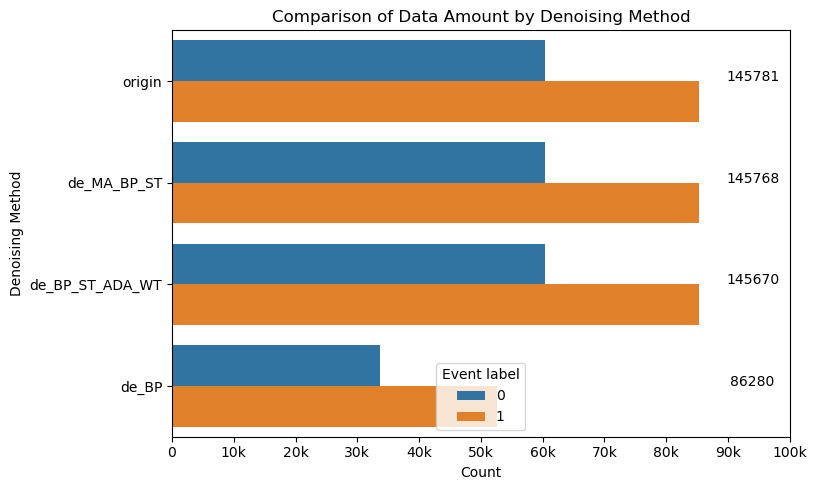

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
HP_ALL_PATH = "./hp_all/all_segments_with_optimal_denoise/"
dir_list = next(walk(HP_ALL_PATH), (None, None, []))[1] # get all dir
print(dir_list)
data = []
data.append(("origin", 0, org_neg_count))
data.append(("origin", 1, org_pos_count+1))
for method in dir_list:
    path = f"/home/bobo/Desktop/bobo/P4_FTP_Data/bobo/hp_all/all_segments_with_optimal_denoise/{method}/all_optimal_denoise.h5"
    df = pd.read_hdf(path, key='data')
    counts = df['Event label'].value_counts()
    for event, count in counts.items():
        data.append((method, event, count))

# Convert to DataFrame for easier plotting
data_df = pd.DataFrame(data, columns=['Method', 'Event label', 'Count']).sort_values(by=['Count'], ascending=False)

# Create bar plot
plt.figure(figsize=(8.27, 5), dpi=100)
sns.barplot(y='Method', x='Count', hue='Event label', data=data_df, orient='h')  # Set orient='h' for horizontal bars

# plot the value on each bar
for index, row in data_df.groupby('Method').sum().sort_values(by=['Count'], ascending=False).reset_index().iterrows():
    plt.text(94000, index, row.Count, color='black', ha="center")

plt.title('Comparison of Data Amount by Denoising Method')
plt.legend(title="Event label", loc='lower center')
plt.xlabel('Count')
plt.ylabel('Denoising Method')
plt.xticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000,  80000, 90000, 100000], ['0', '10k', '20k', '30k', '40k', '50k', '60k', '70k', '80k', '90k', '100k']) # Rotating the x-labels for better visibility if needed
plt.savefig("./png/optimal_denoise/comparison_of_data_amount_by_optimal_denoise.png", facecolor='white', transparent=False, format='png')
plt.show()

In [42]:
import pandas as pd

denoise_methods = [
    "de_BP_ST",
    "de_BP_ST_ADA_WT",
    "de_MA_BP_ST",
    "de_MA_BP_ST_ADA_WT",
    "de_BP",
    "de_BP_MA",
    "de_Elgendi",
    "de_MA",
    "de_MA_BP",
    "de_NF",
    "de_SC",
    "de_WT",
    "de_MA_BP_WT",
    "de_MA_BP_WT",
    "de_MA_WT_BP",
    "de_MA_WT_SC_NF_BP",
    "de_WT_BP",
    "de_WT_MA_SC_NF_BP",
    "de_WT_NF_BP",
    "de_WT_NF_BP",
    "de_WT_SC_NF_BP"
]

# Create a dictionary to store the one-hot encoded data
data = {}
for method in denoise_methods:
    blocks = method.split("_")[1:]  # Extract the denoise blocks (columns)
    for block in blocks:
        data.setdefault(method, {})[block] = 1
    # Fill in 0 for the remaining columns
    for block in ["BP", "ST", "ADA", "WT", "MA", "NF", "SC"]:
        if block not in blocks:
            data.setdefault(method, {})[block] = 0

# Create a dataframe from the dictionary
df = pd.DataFrame(data).T
df.index.name = "Method"  # Set the index name

# Convert the dataframe to LaTeX table
latex_table = df.to_latex()

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lrrrrrrrr}
\toprule
{} &   BP &   ST &  ADA &   WT &   MA &   NF &   SC &  Elgendi \\
Method             &      &      &      &      &      &      &      &          \\
\midrule
de\_BP\_ST           &  1.0 &  1.0 &  0.0 &  0.0 &  0.0 &  0.0 &  0.0 &      NaN \\
de\_BP\_ST\_ADA\_WT    &  1.0 &  1.0 &  1.0 &  1.0 &  0.0 &  0.0 &  0.0 &      NaN \\
de\_MA\_BP\_ST        &  1.0 &  1.0 &  0.0 &  0.0 &  1.0 &  0.0 &  0.0 &      NaN \\
de\_MA\_BP\_ST\_ADA\_WT &  1.0 &  1.0 &  1.0 &  1.0 &  1.0 &  0.0 &  0.0 &      NaN \\
de\_BP              &  1.0 &  0.0 &  0.0 &  0.0 &  0.0 &  0.0 &  0.0 &      NaN \\
de\_BP\_MA           &  1.0 &  0.0 &  0.0 &  0.0 &  1.0 &  0.0 &  0.0 &      NaN \\
de\_Elgendi         &  0.0 &  0.0 &  0.0 &  0.0 &  0.0 &  0.0 &  0.0 &      1.0 \\
de\_MA              &  0.0 &  0.0 &  0.0 &  0.0 &  1.0 &  0.0 &  0.0 &      NaN \\
de\_MA\_BP           &  1.0 &  0.0 &  0.0 &  0.0 &  1.0 &  0.0 &  0.0 &      NaN \\
de\_NF              &  0.0 &  0.0 &  0.0 &  0.0 

/tmp/ipykernel_51413/426238621.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex()


In [43]:
# fill na with 0
df = df.fillna(0)
# change flaot columns to int coluns
df = df.astype(int)
df

,BP,ST,ADA,WT,MA,NF,SC,Elgendi
Method,,,,,,,,
de_BP_ST,1,1,0,0,0,0,0,0
de_BP_ST_ADA_WT,1,1,1,1,0,0,0,0
de_MA_BP_ST,1,1,0,0,1,0,0,0
de_MA_BP_ST_ADA_WT,1,1,1,1,1,0,0,0
de_BP,1,0,0,0,0,0,0,0
de_BP_MA,1,0,0,0,1,0,0,0
de_Elgendi,0,0,0,0,0,0,0,1
de_MA,0,0,0,0,1,0,0,0
de_MA_BP,1,0,0,0,1,0,0,0


In [44]:
df.sum(axis=1)

Method
de_BP_ST              2
de_BP_ST_ADA_WT       4
de_MA_BP_ST           3
de_MA_BP_ST_ADA_WT    5
de_BP                 1
de_BP_MA              2
de_Elgendi            1
de_MA                 1
de_MA_BP              2
de_NF                 1
de_SC                 1
de_WT                 1
de_MA_BP_WT           3
de_MA_WT_BP           3
de_MA_WT_SC_NF_BP     5
de_WT_BP              2
de_WT_MA_SC_NF_BP     5
de_WT_NF_BP           3
de_WT_SC_NF_BP        4
dtype: int64

In [48]:
import pandas as pd



# Sort the DataFrame by row sum and index


df['RowSum'] = df.sum(axis=1)
df_sorted = df.sort_values(by=['RowSum', 'Method'], ascending=[True, True])


# Move rows with 'ADA' to the bottom
ada_rows = df_sorted[df_sorted.index.str.contains('ADA')]
non_ada_rows = df_sorted[~df_sorted.index.str.contains('ADA')]
df_sorted = pd.concat([non_ada_rows, ada_rows])

# Remove the temporary 'RowSum' column
df_sorted.drop('RowSum', axis=1, inplace=True)

df_sorted = df_sorted.sort_index(axis=1)

# Print the sorted DataFrame
display(df_sorted)


# Convert DataFrame to LaTeX table
latex_table = df_sorted.to_latex(index=True)

# Print LaTeX table
print(latex_table)


,ADA,BP,Elgendi,MA,NF,SC,ST,WT
Method,,,,,,,,
de_BP,0,1,0,0,0,0,0,0
de_Elgendi,0,0,1,0,0,0,0,0
de_MA,0,0,0,1,0,0,0,0
de_NF,0,0,0,0,1,0,0,0
de_SC,0,0,0,0,0,1,0,0
de_WT,0,0,0,0,0,0,0,1
de_BP_MA,0,1,0,1,0,0,0,0
de_BP_ST,0,1,0,0,0,0,1,0
de_MA_BP,0,1,0,1,0,0,0,0


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  ADA &  BP &  Elgendi &  MA &  NF &  SC &  ST &  WT \\
Method             &      &     &          &     &     &     &     &     \\
\midrule
de\_BP              &    0 &   1 &        0 &   0 &   0 &   0 &   0 &   0 \\
de\_Elgendi         &    0 &   0 &        1 &   0 &   0 &   0 &   0 &   0 \\
de\_MA              &    0 &   0 &        0 &   1 &   0 &   0 &   0 &   0 \\
de\_NF              &    0 &   0 &        0 &   0 &   1 &   0 &   0 &   0 \\
de\_SC              &    0 &   0 &        0 &   0 &   0 &   1 &   0 &   0 \\
de\_WT              &    0 &   0 &        0 &   0 &   0 &   0 &   0 &   1 \\
de\_BP\_MA           &    0 &   1 &        0 &   1 &   0 &   0 &   0 &   0 \\
de\_BP\_ST           &    0 &   1 &        0 &   0 &   0 &   0 &   1 &   0 \\
de\_MA\_BP           &    0 &   1 &        0 &   1 &   0 &   0 &   0 &   0 \\
de\_WT\_BP           &    0 &   1 &        0 &   0 &   0 &   0 &   0 &   1 \\
de\_MA\_BP\_ST        &    0 &   1 &        0

/tmp/ipykernel_51413/2861409638.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_sorted.to_latex(index=True)


## Pareto optimal solutions